In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py


/home/ge96sur/environments/domain_adaptation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
with h5py.File("data/raw/john_pentacene.h5", "r") as file:
    # list top-level groups/datasets in file
    print(file.keys())

    # get information about group/dataset
    print(file.get("/"))
    print(file.get("atoms"))
    print(file.get("positions"))
    print(file.get("transfer_integrals"))

    # get content and convert to numpy arrays
    atoms = file.get("atoms")[()].astype(str)
    positions = file.get("positions")[()]
    transfer_integrals = file.get("transfer_integrals")[()] # TODO: transform target with log # TODO: transform target with log


<KeysViewHDF5 ['atoms', 'positions', 'transfer_integrals']>
<HDF5 group "/" (3 members)>
<HDF5 dataset "atoms": shape (72,), type "|S2">
<HDF5 dataset "positions": shape (535246, 72, 3), type "<f4">
<HDF5 dataset "transfer_integrals": shape (535246,), type "<f4">


# Graphs for pentacene

(-50.0, 50.0)

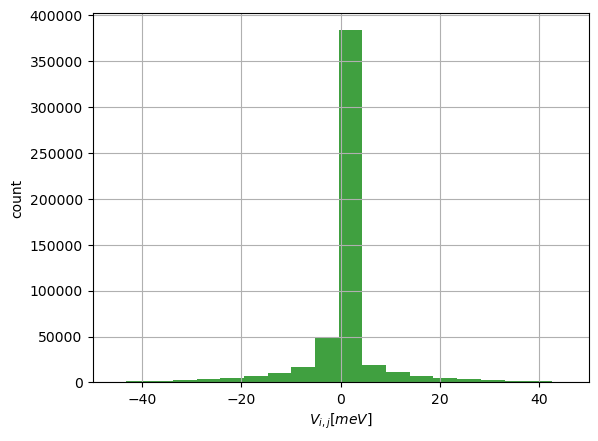

In [3]:
plt.xlabel(r'$V_{i,j} [meV]$')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(transfer_integrals*1000, bins=50, facecolor='g', alpha=0.75 )
plt.xlim(-50,50)

(0.0, 50.0)

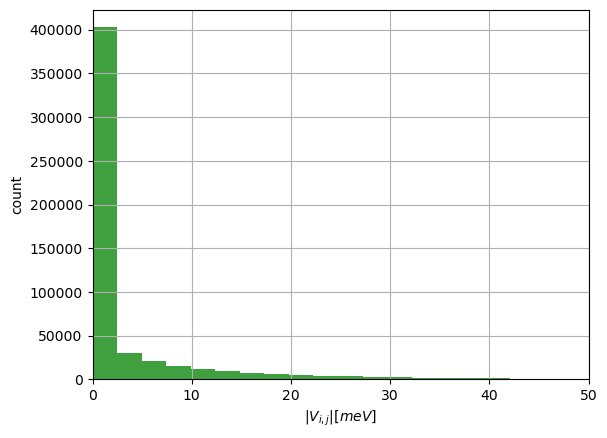

In [4]:
plt.xlabel(r'$|V_{i,j}| [meV]$')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(np.abs(transfer_integrals)*1000, bins=50, facecolor='g', alpha=0.75 )
plt.xlim(0,50)

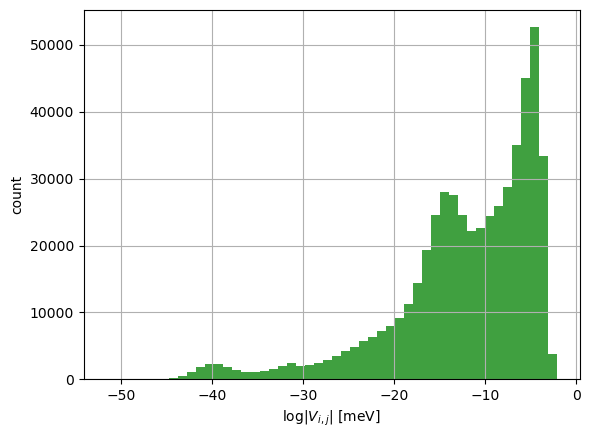

In [5]:
# absolute values of transfer integral: 
plt.xlabel(r'$ \log |V_{i,j}|$ [meV]')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(np.log10(np.abs(transfer_integrals[transfer_integrals!=0])), bins=50, facecolor='g', alpha=0.75 )
# plt.xlim(0,50)

In [6]:
# how many nan or inf? nan is obtained when log is applied to a number lower than zero.
#                      inf is obtained by applying log to zero
# we apply log to absolute value (i.e. there are no negatives), therefore we discard only inf values.
print('number of infs: ', np.sum(np.abs(transfer_integrals)==0.)) 
print(f'there will be a fraction of {(np.sum(np.abs(transfer_integrals)==0.) / len(transfer_integrals)):.2f} discarded values from the total.')
# two percent of data shall be discarded.



number of infs:  11499
there will be a fraction of 0.02 discarded values from the total.


In [7]:
# distribution of log transfer integral after elimination of these terms: 
np.sum(np.isinf(np.log(np.abs(transfer_integrals))))

/tmp/ipykernel_1389039/2931256229.py:2: RuntimeWarning: divide by zero encountered in log
  np.sum(np.isinf(np.log(np.abs(transfer_integrals))))


11499

## Bond matrix


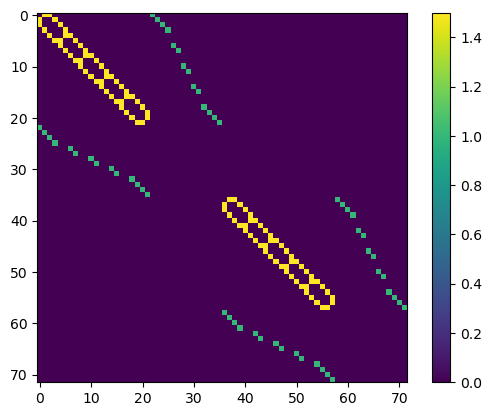

In [8]:
import matplotlib.pyplot as plt

# construct bond matrix:
bonds = np.zeros((len(atoms), len(atoms)))
arom = 1.5
single = 1 
counter = 22

for i in range(len(atoms)):
    # aromatic
    if ((i%4 == 0) and ((i<=16) or ((i>=36) & (i<=52)))):
        bonds[i, i+1],   bonds[i+1, i] = (arom, arom) # (0,1)
        bonds[i, i+2],   bonds[i+2, i] = (arom, arom) # (0,2)
        bonds[i+3, i+1], bonds[i+1, i+3] = (arom, arom) # (3,1)
        bonds[i+3, i+5], bonds[i+5, i+3] = (arom, arom) # (3,5)
        bonds[i+4, i+2], bonds[i+2, i+4] = (arom, arom) # (4,2)
        bonds[i+4, i+5], bonds[i+5, i+4] = (arom, arom) # (4,5)    
    # single
    if ((i<=20) or ((i>=36) & (i<=56))):
        if (i%4==2): 
            bonds[i,i+counter], bonds[i+counter, i] = (single, single)
        if (i%4==3):
            bonds[i,i+counter], bonds[i+counter,i] = (single, single)
            counter-=2 
    if i==22:
        counter=22 
 

    # boundary bonds
    bonds[0,22], bonds[22,0] = (single, single)
    bonds[1,23], bonds[23,1] = (single, single)
    bonds[20,34], bonds[34,20] = (single, single)
    bonds[21,35], bonds[35,21] = (single, single)

    bonds[36,58], bonds[58,36] = (single, single)
    bonds[37,59], bonds[59,37] = (single, single)
    bonds[56, 70], bonds[70, 56] = (single, single)
    bonds[57,71], bonds[71,57] = (single, single)
    
# plot bond matrix
fig, axis = plt.subplots()
hmap = axis.imshow(bonds)
bar = plt.colorbar(hmap)
plt.show()

In [9]:
# %matplotlib widget
# # %matplotlib notebook
# fig, ax = plt.subplots()

# ax.scatter(positions[0][:36])

In [10]:
np.sum(bonds, axis=1) 
# bond matrix might be wrong for some atoms! in fact the number of total bond for each atoms exceeds 4

array([4. , 4. , 4. , 4. , 4.5, 4.5, 4. , 4. , 4.5, 4.5, 4. , 4. , 4.5,
       4.5, 4. , 4. , 4.5, 4.5, 4. , 4. , 4. , 4. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 4. , 4. , 4. ,
       4. , 4.5, 4.5, 4. , 4. , 4.5, 4.5, 4. , 4. , 4.5, 4.5, 4. , 4. ,
       4.5, 4.5, 4. , 4. , 4. , 4. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. ])

## Coulomb matrix


/tmp/ipykernel_1389039/1481464934.py:6: RuntimeWarning: divide by zero encountered in true_divide
  cm = (atomic_nums*atomic_nums.T) / pairwise_distances(positions[0])


[]

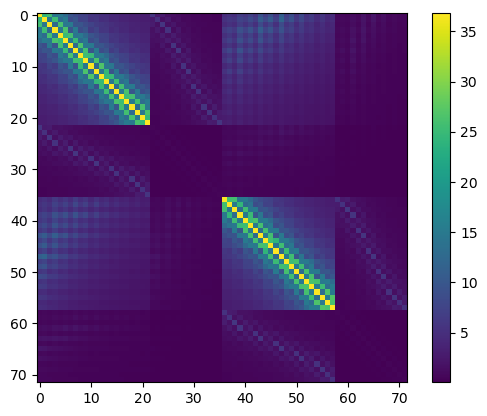

In [11]:
#%%
# create coulomb matrix for a single instance 
from sklearn.metrics import pairwise_distances
atom_to_num = {'H': 1, 'C': 6}
atomic_nums = np.asarray([atom_to_num[atom] for atom in atoms])[:, np.newaxis]
cm = (atomic_nums*atomic_nums.T) / pairwise_distances(positions[0])
np.fill_diagonal(cm, 0.5*atomic_nums**2.4)

fig, axis = plt.subplots()
hmap = axis.imshow(cm)
bar = plt.colorbar(hmap)
# fig.savefig("coulomb_matrix.png")
plt.plot()

## Stratified sampling
We attempt to make the dataset more symmetric by sampling instances equally.

Find distribution of distance of centers of mass:
each position is weighted by the atomic mass of the atom.

Carbon: 12.01
Hydrogen: 1.01

One can distringuish the three main peaks due to typical orientations of molecules in a crystal.

### Histogram of distance between centers of masses


In [12]:
atom_to_atomic_mass = {'C':12.01, 'H':1.01, 'S':32.065}
atomic_masses = [atom_to_atomic_mass[el] for el in atoms]
atomic_masses = (atomic_masses / np.linalg.norm(atomic_masses, ord=1))[:,np.newaxis]

weighted_pos = positions * atomic_masses
cm_1 = np.sum(weighted_pos[:,:36,:], axis=1) # center of masses of the two molecules
cm_2 = np.sum(weighted_pos[:,36:,:], axis=1)

dist = np.linalg.norm(cm_1 - cm_2, axis=1)




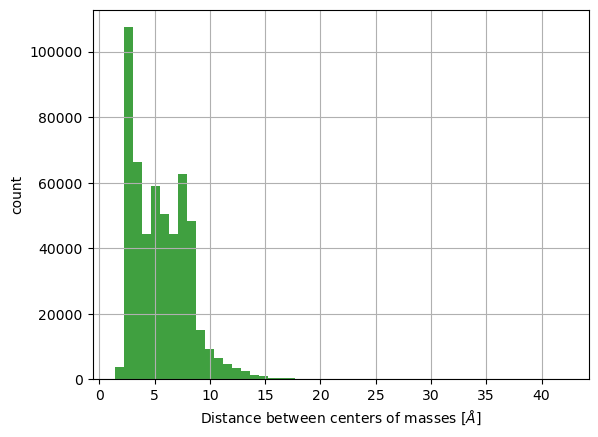

In [13]:
# plot distribution of distances. We will want to sample equally from molecules with these three orientations.
plt.xlabel(r'Distance between centers of masses [$\AA$]')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(dist, bins=50, facecolor='g', alpha=0.75 )
plt.xlim(0,20)

In [14]:
# from scipy import stats
# stats.binned_statistic(dist[dist<18], dist[dist<18], statistic='mean', bins=5)

In [11]:
# removing molecules that are distanct does not change the shape of the histogram of log(abs(V)).
# does stratify sampling based on distances really help?

# we perform stratified sampling based on the target.
# log target
positions = positions[transfer_integrals!=0]
transfer_integrals = np.log(np.abs(transfer_integrals[transfer_integrals!=0])) # NOTE: this cell modifies the transfer integral

stratify = 30
debug_size = 2000


bins = np.linspace(transfer_integrals.min(), transfer_integrals.max(), stratify)
transfer_integrals_binned = np.digitize(transfer_integrals, bins)
stratified_transfer_int = np.asarray([])
stratified_pos = np.asarray([]).reshape(0,72,3)
pop_size = np.floor_divide(debug_size,stratify)
# sample equally for each bin (possible the number of sample in each bin should be the same)
for stratum in range(1,stratify):
    print(f'Getting {np.sum(transfer_integrals_binned==stratum)} samples for stratum {stratum}.')
    mask = (transfer_integrals_binned==stratum)
    stratified_transfer_int = np.concatenate((stratified_transfer_int, transfer_integrals[mask][:pop_size]))
    stratified_pos = np.concatenate((stratified_pos, positions[mask][:pop_size]))

if len(stratified_transfer_int) != debug_size: # to fill up debug size, sample randomly with replacement
    rng = np.random.default_rng(42)
    sample_size = debug_size - len(stratified_transfer_int) 
    mask = rng.choice(np.arange(len(transfer_integrals)), size=sample_size, replace=False, shuffle=False)
    stratified_transfer_int = np.concatenate((stratified_transfer_int, transfer_integrals[mask]))
    stratified_pos = np.concatenate((stratified_pos, positions[mask]))
transfer_integrals = stratified_transfer_int
positions = stratified_pos

Getting 1 samples for stratum 1.
Getting 5 samples for stratum 2.
Getting 33 samples for stratum 3.
Getting 122 samples for stratum 4.
Getting 579 samples for stratum 5.
Getting 1904 samples for stratum 6.
Getting 3727 samples for stratum 7.
Getting 3656 samples for stratum 8.
Getting 2470 samples for stratum 9.
Getting 1988 samples for stratum 10.
Getting 2547 samples for stratum 11.
Getting 3821 samples for stratum 12.
Getting 3713 samples for stratum 13.
Getting 4140 samples for stratum 14.
Getting 5501 samples for stratum 15.
Getting 7586 samples for stratum 16.
Getting 9605 samples for stratum 17.
Getting 12047 samples for stratum 18.
Getting 14594 samples for stratum 19.
Getting 19975 samples for stratum 20.
Getting 31950 samples for stratum 21.
Getting 46039 samples for stratum 22.
Getting 46065 samples for stratum 23.
Getting 38728 samples for stratum 24.
Getting 41284 samples for stratum 25.
Getting 46682 samples for stratum 26.
Getting 63606 samples for stratum 27.
Getting 87

In [15]:
len(transfer_integrals)

100

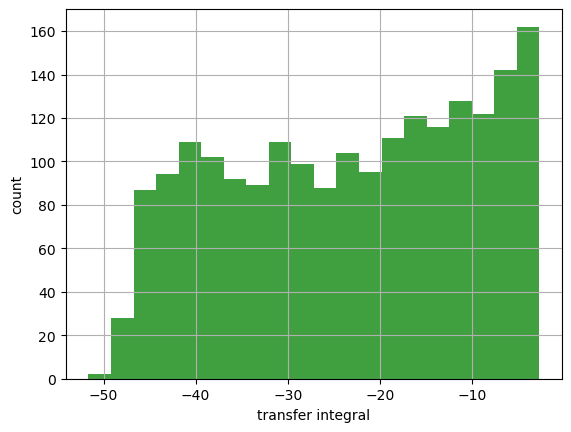

In [13]:
# plot distribution of stratified samples. 
plt.xlabel(r'transfer integral')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(stratified_transfer_int, bins=20, facecolor='g', alpha=0.75 )
# plt.xlim(0,50)

-51.651672

# DNTT


In [4]:
with h5py.File("data/raw/john_DNTT.h5", "r") as file:
    # list top-level groups/datasets in file
    print(file.keys())

    # get information about group/dataset
    print(file.get("/"))
    print(file.get("atoms"))
    print(file.get("positions"))
    print(file.get("transfer_integrals"))

    # get content and convert to numpy arrays
    atoms = file.get("atoms")[()].astype(str)
    positions = file.get("positions")[()]
    transfer_integrals = file.get("transfer_integrals")[()] # TODO: transform target with log # TODO: transform target with log


<KeysViewHDF5 ['atoms', 'positions', 'transfer_integrals']>
<HDF5 group "/" (3 members)>
<HDF5 dataset "atoms": shape (72,), type "|S2">
<HDF5 dataset "positions": shape (33530, 72, 3), type "<f4">
<HDF5 dataset "transfer_integrals": shape (33530,), type "<f4">


## Transfer integral $V_{i,j}$


(-50.0, 50.0)

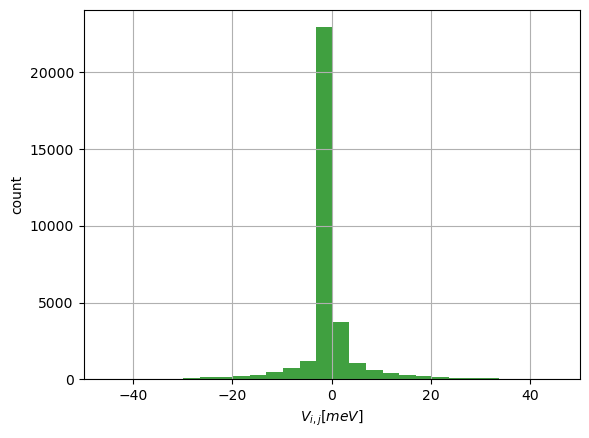

In [5]:
plt.xlabel(r'$V_{i,j} [meV]$')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(transfer_integrals*1000, bins=50, facecolor='g', alpha=0.75 )
plt.xlim(-50,50)

## Absolute transfer integral $|V_{i,j}|$

(0.0, 50.0)

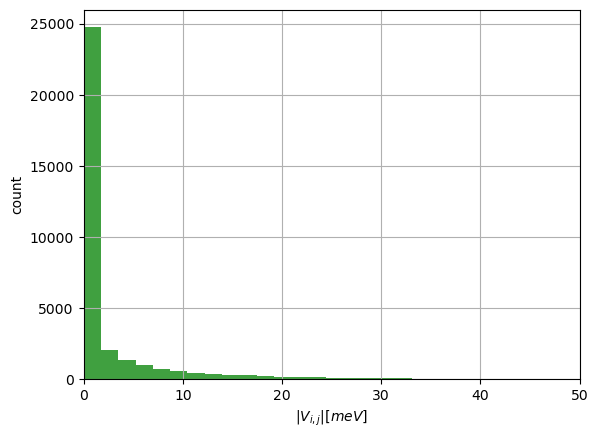

In [6]:
plt.xlabel(r'$|V_{i,j}| [meV]$')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(np.abs(transfer_integrals)*1000, bins=50, facecolor='g', alpha=0.75 )
plt.xlim(0,50)

## Log of absolute transfer integral $\log |V_{i,j}|$

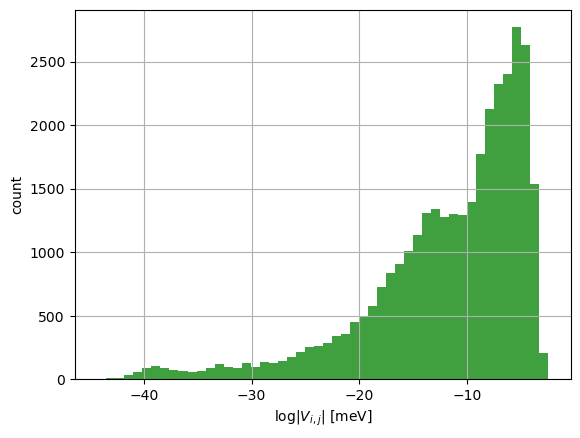

In [7]:
# absolute values of transfer integral: 
plt.xlabel(r'$ \log |V_{i,j}|$ [meV]')
plt.ylabel('count')
plt.grid(True)

n, bins, patches = plt.hist(np.log10(np.abs(transfer_integrals[transfer_integrals!=0])), bins=50, facecolor='g', alpha=0.75 )
# plt.xlim(0,50)

# Creating train and test datasets

In [17]:
# creating train and test datasets in h5 format
# load data
name = 'pentacene'
read_path = "NN_conv_net/data/raw/john_" + name + ".h5"
with h5py.File(read_path, "r") as file:
    # list top-level groups/datasets in file
    print(file.keys())

    # get information about group/dataset
    print(file.get("/"))
    print(file.get("atoms"))
    print(file.get("positions"))
    print(file.get("transfer_integrals"))

    # get content and convert to numpy arrays
    atoms = file.get("atoms")[()]
    positions = file.get("positions")[()]
    transfer_integrals = file.get("transfer_integrals")[()]
    


<KeysViewHDF5 ['atoms', 'positions', 'transfer_integrals']>
<HDF5 group "/" (3 members)>
<HDF5 dataset "atoms": shape (72,), type "|S2">
<HDF5 dataset "positions": shape (535246, 72, 3), type "<f4">
<HDF5 dataset "transfer_integrals": shape (535246,), type "<f4">


In [18]:
# mix it (pos and transfer integrals with same seed.)
# TODO
# divide in half and save each half into {}_train and {}_test data
cut = (len(positions)//2)
positions_train = positions[:cut]
positions_test = positions[cut:]
transfer_integrals_train = transfer_integrals[:cut]
transfer_integrals_test = transfer_integrals[cut:]



In [19]:
save_path = "NN_conv_net/data/raw/" + name
with h5py.File(save_path + "_train.h5", 'w') as hf:
    hf.create_dataset('atoms', data=atoms)
    hf.create_dataset('positions', data=positions_train)
    hf.create_dataset('transfer_integrals', data=transfer_integrals_train)
    
with h5py.File(save_path + "_test.h5", 'w') as hf:
    hf.create_dataset('atoms', data=atoms)
    hf.create_dataset('positions', data=positions_test)
    hf.create_dataset('transfer_integrals', data=transfer_integrals_test)
    


In [22]:
# check opening correctly 
name = 'pentacene'
read_path = "NN_conv_net/data/raw/" + name + "_train.h5"
with h5py.File(read_path, "r") as file:
    # list top-level groups/datasets in file
    print(file.keys())

    # get information about group/dataset
    print(file.get("/"))
    print(file.get("atoms"))
    print(file.get("positions"))
    print(file.get("transfer_integrals"))

    # get content and convert to numpy arrays
    atoms = file.get("atoms")[()].astype(str)
    positions = file.get("positions")[()]
    transfer_integrals = file.get("transfer_integrals")[()]

<KeysViewHDF5 ['atoms', 'positions', 'transfer_integrals']>
<HDF5 group "/" (3 members)>
<HDF5 dataset "atoms": shape (72,), type "|S2">
<HDF5 dataset "positions": shape (267623, 72, 3), type "<f4">
<HDF5 dataset "transfer_integrals": shape (267623,), type "<f4">


In [16]:
len(positions)

267623